In [ ]:
# Load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Ensure directory exists
os.makedirs("visualisations", exist_ok=True)

In [23]:
# Load data
crash_facts = pd.read_excel("data/crash_fact_table.xlsx")
data_dimensions = pd.read_excel("data/date_dimension.xlsx")
location_dimensions = pd.read_excel("data/location_dimension.xlsx")

/tmp/ipykernel_4408/881656923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=crash_facts["Crash_Speed_Limit"], order=crash_facts["Crash_Speed_Limit"].value_counts().index, palette="viridis")


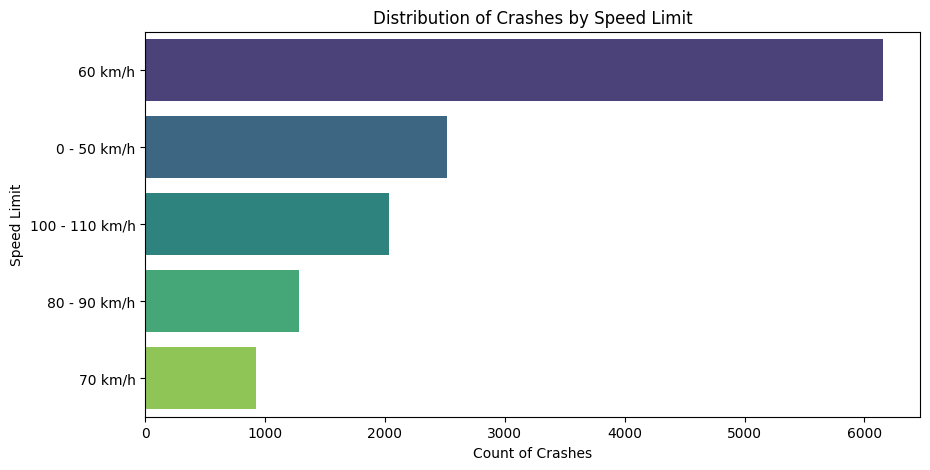

In [ ]:
# Analysing the frequency of crashes in each speed zone (note that this doesnt account for the fact that more people drive in lower speed limit zones)
plt.figure(figsize=(10, 5))
sns.countplot(y=crash_facts["Crash_Speed_Limit"], order=crash_facts["Crash_Speed_Limit"].value_counts().index, palette="viridis")
plt.xlabel("Count of Crashes")
plt.ylabel("Speed Limit")
plt.title("Distribution of Crashes by Speed Limit")
plt.show()

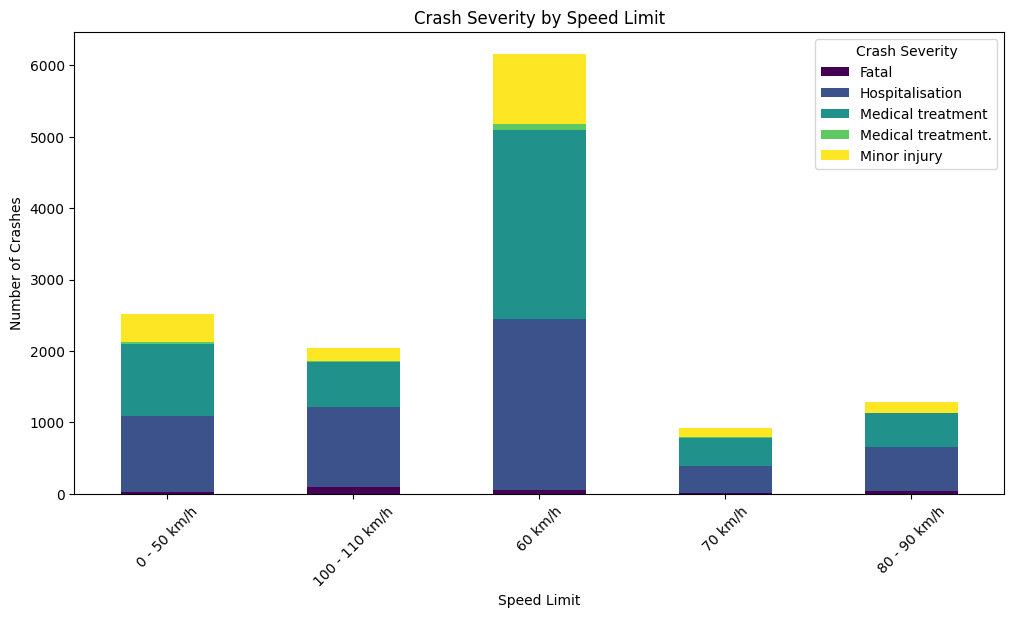

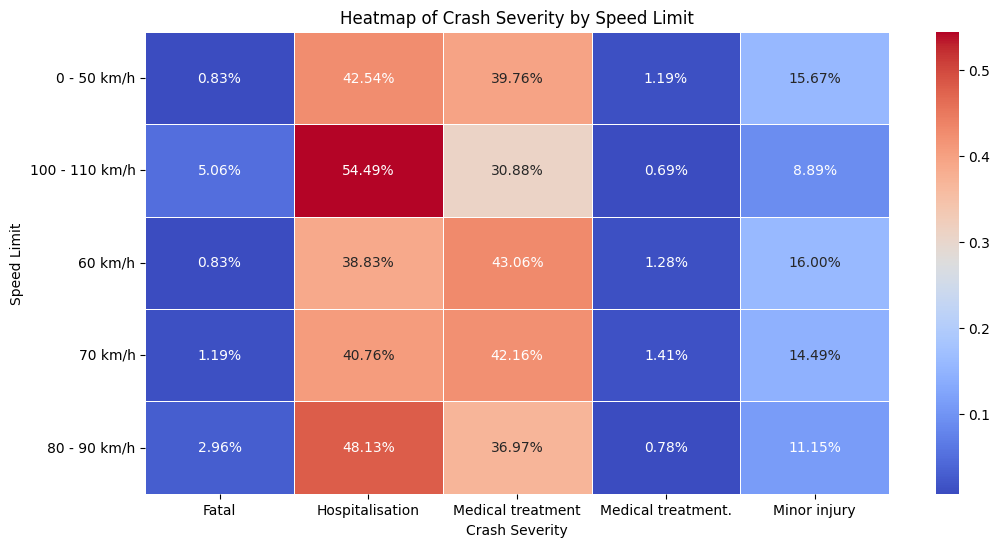

In [29]:
# PCreate pivot table for stacked bar chart
severity_counts = crash_facts.pivot_table(index="Crash_Speed_Limit", columns="Crash_Severity", aggfunc="size", fill_value=0)

# Plot
severity_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Speed Limit")
plt.ylabel("Number of Crashes")
plt.title("Crash Severity by Speed Limit")
plt.legend(title="Crash Severity")
plt.xticks(rotation=45)
plt.savefig("visualisations/crash_severity_barchart.png")
plt.show()


# For the heatmap, normalise the data to remove bias of areas with more total crashes due to more traffic.
heatmap_data = severity_counts.div(severity_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Crash Severity")
plt.ylabel("Speed Limit")
plt.title("Heatmap of Crash Severity by Speed Limit")
plt.savefig("visualisations/crash_severity_heatmap.png")
plt.show()
